In [1]:
import xarray as xr
import numpy as np

import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import cartopy.crs as ccrs

import os

## Open the data

In [2]:
regions = ["MED", "Chile", "Greece", "Bolivia", "Canada", "NWN", 'NW_Amazon']
#regions = ['NW_Amazon']
scenarios = ['historical', 'ssp126', 'ssp370', 'ssp585']
climate_models = ['GFDL-ESM4', 'IPSL-CM6A-LR', 'MPI-ESM1-2-HR', 'MRI-ESM2-0', 'UKESM1-0-LL']

#### Either choose treecover

In [5]:
filepath = "../../wildfire_data.nosync/plots/treecover/"

datastore_treecover = {}

for region in regions:

    for cm in climate_models:
        
        key_cm_hist = region+'_'+cm+'_cm_hist'
        key_obs = region+'_'+cm+'_obs'
        
        tree_cover_cm_hist = xr.open_dataset("../../wildfire_data.nosync/"+region+"/isimp3a/obsclim/GSWP3-W5E5/period_2002_2019/tree_cover_jules-es.nc")
        tree_cover_obs = xr.open_dataset("../../wildfire_data.nosync/"+region+"/isimp3a/obsclim/GSWP3-W5E5/period_2002_2019/tree_cover_VCF-obs.nc")
    
        # Cut to right area
        obs_latitudes = tree_cover_obs.latitude.values
        obs_longitudes = tree_cover_obs.longitude.values

        if region in ["MED", "Chile"]:
            tree_cover_cm_hist = tree_cover_cm_hist.sel(
                    lat=slice(max(obs_latitudes), min(obs_latitudes)),
                    lon=slice(min(obs_longitudes), max(obs_longitudes)),
                )


        # Convert obs values
        tree_cover_obs = tree_cover_obs*100

        datastore_treecover[key_cm_hist] = tree_cover_cm_hist
        datastore_treecover[key_obs] = tree_cover_obs
        
        for scenario in scenarios:
            
            if scenario == "historical":
                period = "period_1994_2014"
            else:
                period = "period_2015_2099"

            raw_tree_cover_cm_fut = xr.open_dataset(os.path.join("../../wildfire_data.nosync/", region, "isimp3b", scenario, cm, period, "tree_cover_jules-es.nc"))

            # Cut to the right area
            if region in ["MED", "Chile"]:
                tree_cover_cm_fut = raw_tree_cover_cm_fut.sel(
                    lat=slice(max(obs_latitudes), min(obs_latitudes)),
                    lon=slice(min(obs_longitudes), max(obs_longitudes)),
                )
            else:
                tree_cover_cm_fut = raw_tree_cover_cm_fut

            debiased_tree_cover_cm_fut = xr.open_dataset(os.path.join("../../wildfire_data.nosync/", region, "isimp3b", scenario, cm, period, "debiased_tree_cover_jules-es.nc")).tree_cover#.values

            key_cm_fut = region+'_'+cm+'_'+scenario+'_cm_fut'
            key_cm_fut_debiased = region+'_'+cm+'_'+scenario+'_cm_fut_debiased'
            
            datastore_treecover[key_cm_fut] = tree_cover_cm_fut
            datastore_treecover[key_cm_fut_debiased] =  debiased_tree_cover_cm_fut
            

In [26]:
datastore_treecover['Bolivia_'+climate_models[0]+'_historical_cm_fut']

<xarray.Dataset>
Dimensions:     (time: 21, lat: 27, lon: 26, bnds: 2)
Coordinates:
  * time        (time) datetime64[ns] 1994-07-02T12:00:00 ... 2014-07-02T12:0...
  * lat         (lat) float64 -9.75 -10.25 -10.75 ... -21.75 -22.25 -22.75
  * lon         (lon) float64 -69.75 -69.25 -68.75 ... -58.25 -57.75 -57.25
    month       (time) int64 ...
    year        (time) int64 ...
Dimensions without coordinates: bnds
Data variables:
    tree_cover  (time, lat, lon) float32 nan nan nan nan nan ... nan nan nan nan
    lat_bnds    (lat, bnds) float64 ...
    lon_bnds    (lon, bnds) float64 ...
Attributes:
    comment:            rose-suite is u-cc669_isimip3b_es
    contact:            eleanor.burke@metoffice.gov.uk
    institution:        Met Office
    minimum_weighting:  1e-05
    Conventions:        CF-1.7

In [27]:
datastore_treecover['Bolivia_'+climate_models[0]+'_historical_cm_fut_debiased']

<xarray.DataArray 'tree_cover' (time: 21, lat: 27, lon: 26)>
array([[[nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan],
        ...,
        [nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan]],

       [[nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan],
        ...,
        [nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan]],

       ...,

       [[nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan],
        ...,
        [nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan]],

       [[nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan],
        ...,
        [nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan]]], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1994-07-02T12:00:00 ... 2014-07-02T12:00:00
  * lat      (lat) float64 -9.75 -10.25 -10.75 -11.25 ... -21.75 -22.25 -22.75
  * lon      (lon) float64 -69.75 -69.25 -68.75 -68.25 ... -58.25 -57.75 -57.25
    month    (time) int64 ...
    year     (time) int64 ...
Attributes:
    long_name:  tree_cover
    units:      %

#### ... or no tree cover

### Evaluate marginal bias

In [4]:
from ibicus.evaluate import assumptions, correlation, marginal, multivariate, trend
from ibicus.evaluate.metrics import *
from ibicus.utils._utils import year
from ibicus.utils._utils import _unpack_df_of_numpy_arrays

In [50]:
marginal_bias = []

for region in regions:

    for cm in climate_models:

        obs_data = datastore_treecover[region+'_'+cm+'_obs'].tree_cover.values
        raw_hist_data = datastore_treecover[region+'_'+cm+'_cm_hist'].tree_cover.values
        debiased_hist_data = datastore_treecover[region+'_'+cm+'_historical_cm_fut_debiased'].values
        
        obs_data[obs_data > 1e6] = np.nan
        raw_hist_data[raw_hist_data > 1e6] = np.nan
        debiased_hist_data[debiased_hist_data > 1e6] = np.nan

        bias = marginal.calculate_marginal_bias(obs = obs_data,
                                                                 statistics = ['mean', 0.8], metrics = [], 
                                                                 percentage_or_absolute = 'absolute',
                                                          raw = raw_hist_data,
                                                          debiased = debiased_hist_data)
        bias['Climate Model']=cm
        bias['Region']=region
        marginal_bias.append(bias)
    
marginal_bias_df = pd.concat(marginal_bias)

In [20]:
marginal_bias_df

Correction Method  Metric      Type  \
0                raw    Mean  absolute   
0                raw  0.8 qn  absolute   
0           debiased    Mean  absolute   
0           debiased  0.8 qn  absolute   
0                raw    Mean  absolute   
..               ...     ...       ...   
0           debiased  0.8 qn  absolute   
0                raw    Mean  absolute   
0                raw  0.8 qn  absolute   
0           debiased    Mean  absolute   
0           debiased  0.8 qn  absolute   

                                                 Bias Climate Model     Region  
0   [[nan, nan, nan, nan, nan, nan, nan, nan, nan,...     GFDL-ESM4        MED  
0   [[nan, nan, nan, nan, nan, nan, nan, nan, nan,...     GFDL-ESM4        MED  
0   [[nan, nan, nan, nan, nan, nan, nan, nan, nan,...     GFDL-ESM4        MED  
0   [[nan, nan, nan, nan, nan, nan, nan, nan, nan,...     GFDL-ESM4        MED  
0   [[nan, nan, nan, nan, nan, nan, nan, nan, nan,...  IPSL-CM6A-LR        MED  
..                                                ...           ...        ...  
0   [[-4.423820495605469, -7.512013244628903, -15....    MRI-ESM2-0  NW_Amazon  
0   [[-6.9754505, 33.067448, 25.45926, 11.853497, ...   UKESM1-0-LL  NW_Amazon  
0   [[-9.260025024414062, 25.976027679443362, 15.7...   UKESM1-0-LL  NW_Amazon  
0   [[-1.5880451, -1.5545444, -4.311241, -1.756065...   UKESM1-0-LL  NW_Amazon  
0   [[-4.416038513183594, -7.458771514892575, -15....   UKESM1-0-LL  NW_Amazon  

[140 rows x 6 columns]

#### plot bias of raw model

In [21]:
vmax = [40, 40, 40, 40, 40, 40, 40, 40]

datastore_vmax = {}
i=0
for region in regions:
    datastore_vmax[region] = vmax[i]
    i=i+1

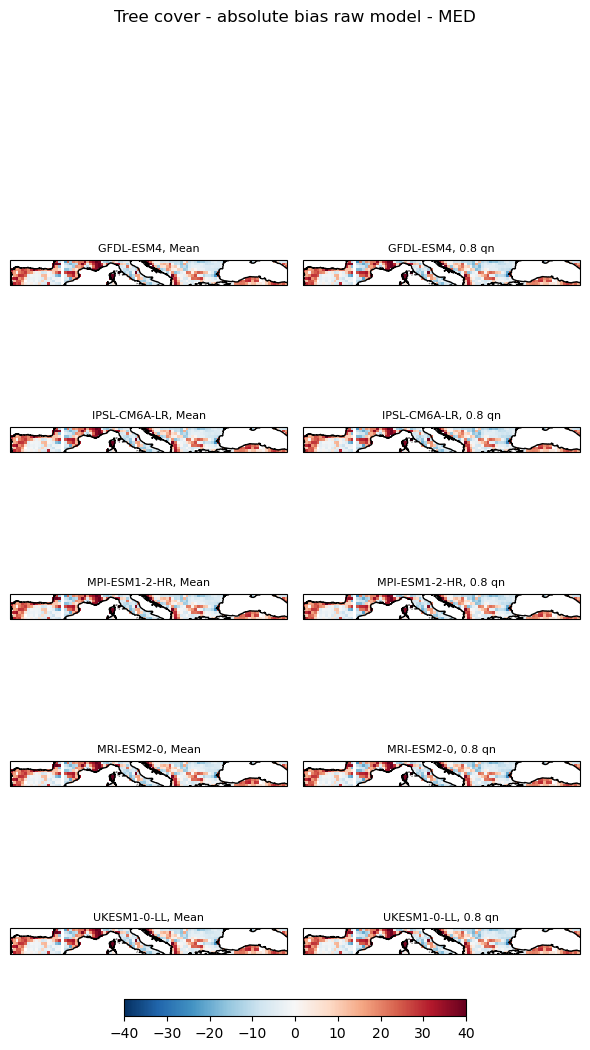

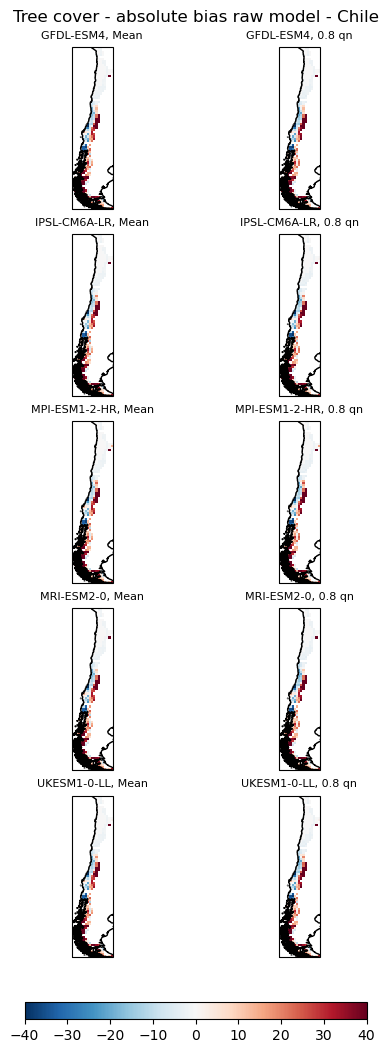

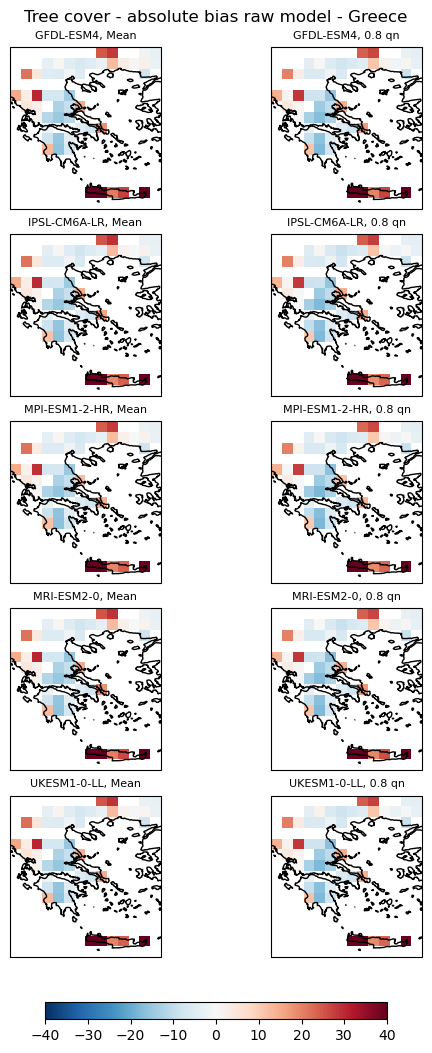

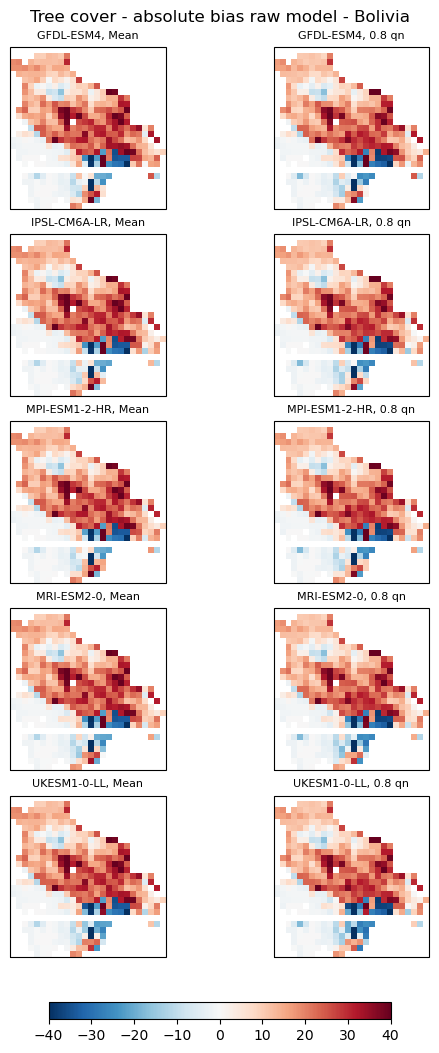

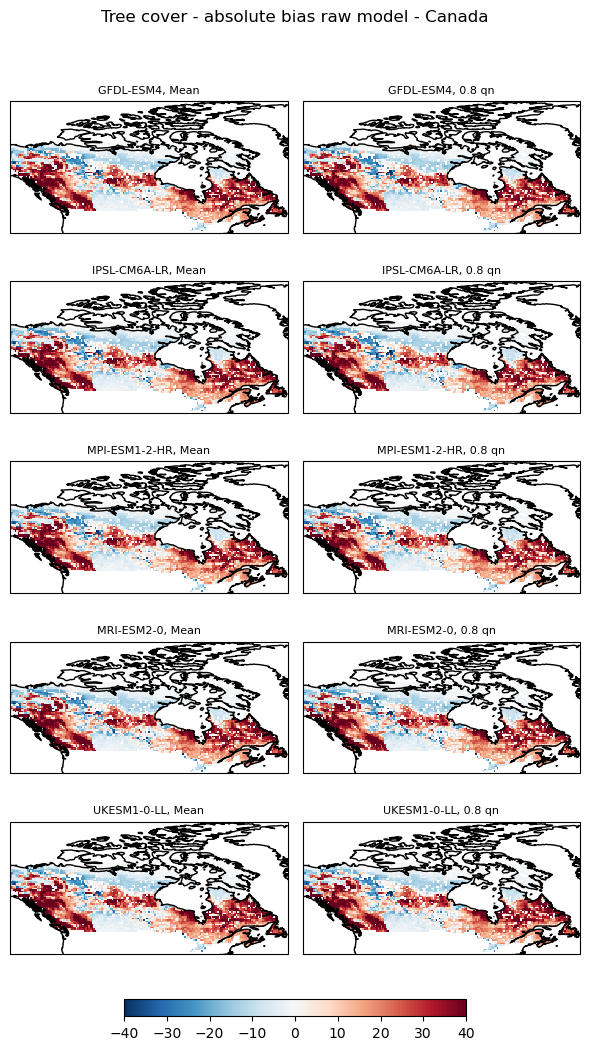

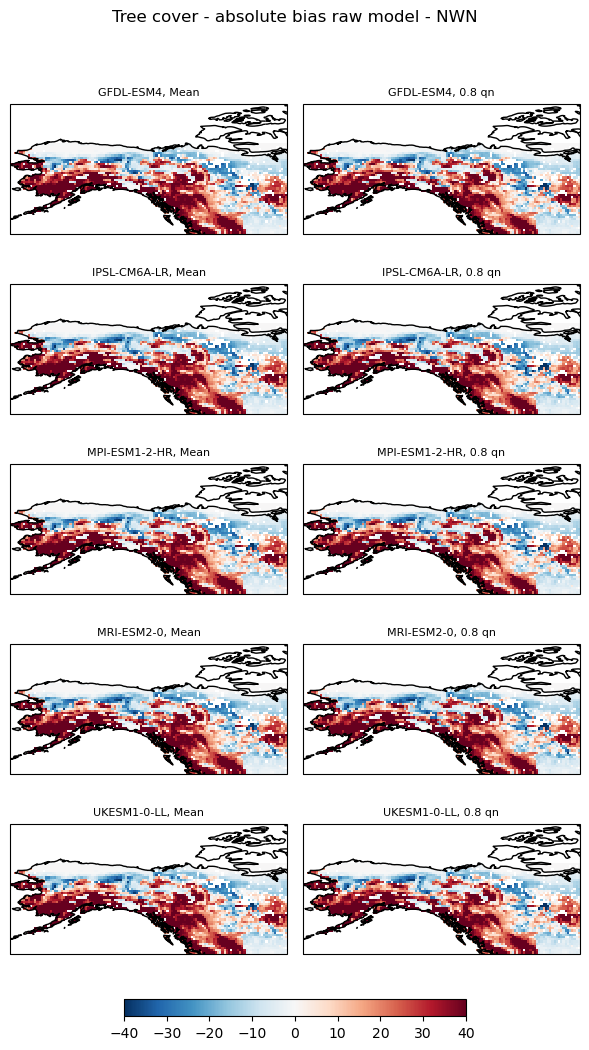

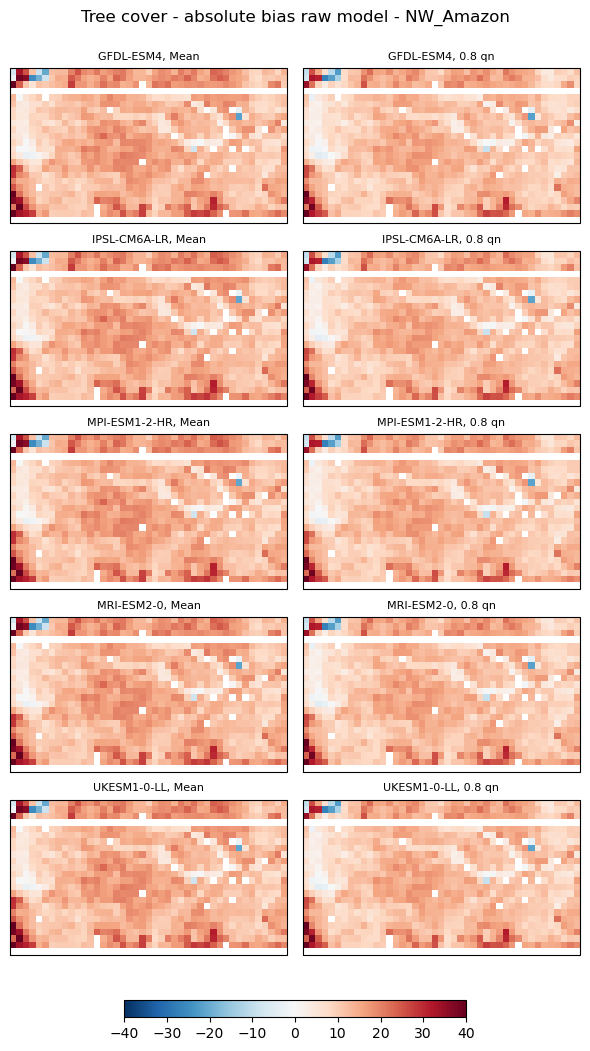

In [22]:
for region in regions:
    
    filtered_data = marginal_bias_df[marginal_bias_df['Correction Method']=='raw']
    filtered_data = filtered_data[filtered_data['Region']==region]

    proj =ccrs.PlateCarree(central_longitude=0)
    fig, axes = plt.subplots(len(climate_models), 2, figsize=(6, 12), subplot_kw=dict(projection=proj))

    axis_max = datastore_vmax[region]
    axis_min = -datastore_vmax[region]

    for i in range(len(filtered_data.index)):
        da_xr = datastore_treecover[region+'_'+filtered_data['Climate Model'].iloc[i]+'_cm_hist'].tree_cover[1, :, :]
        plot_data = xr.DataArray(filtered_data['Bias'].iloc[i], coords=da_xr.coords, dims=da_xr.dims, attrs=da_xr.attrs)

        cs = plot_data.plot(ax=axes.flat[i], cmap='RdBu_r',
                                              transform=ccrs.PlateCarree(), vmin=axis_min, vmax = axis_max,
                                             add_colorbar=False)
        axes.flat[i].coastlines()

        axes.flat[i].set_aspect('equal')
        axes.flat[i].set_title(label = filtered_data['Climate Model'].iloc[i]+', '+filtered_data['Metric'].iloc[i],
                              fontdict = {'fontsize': 8})

    #plt.show()
    fig.suptitle('Tree cover - absolute bias raw model - '+region)
    fig.tight_layout()
    cb = fig.colorbar(cs, ax=axes.ravel().tolist(), location='bottom', shrink=0.6, pad=0.04)
    plt.savefig(filepath+region+'_bias_raw_model.png')

#### plot bias of corrected model

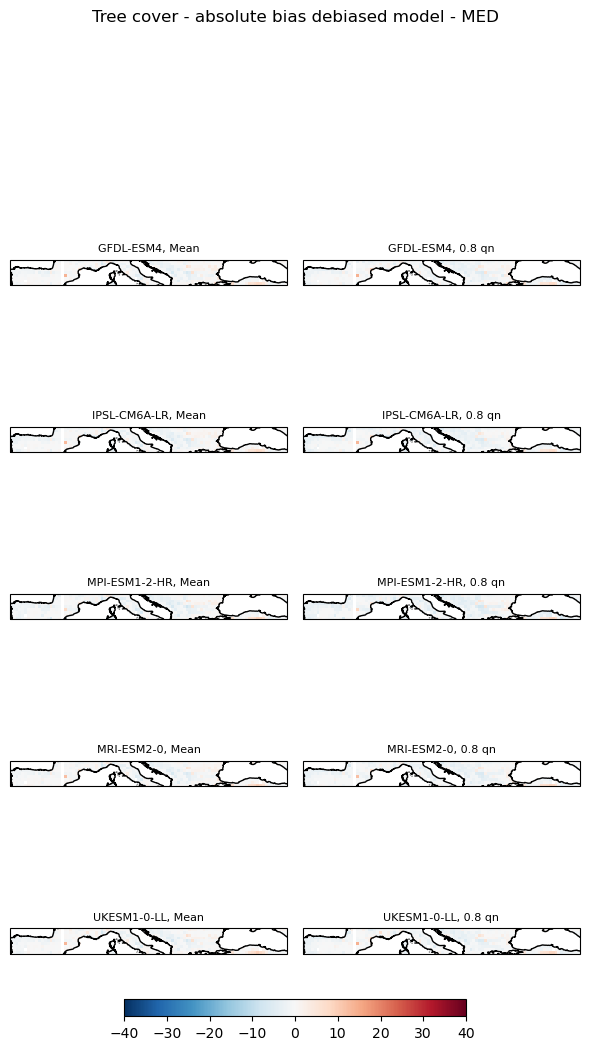

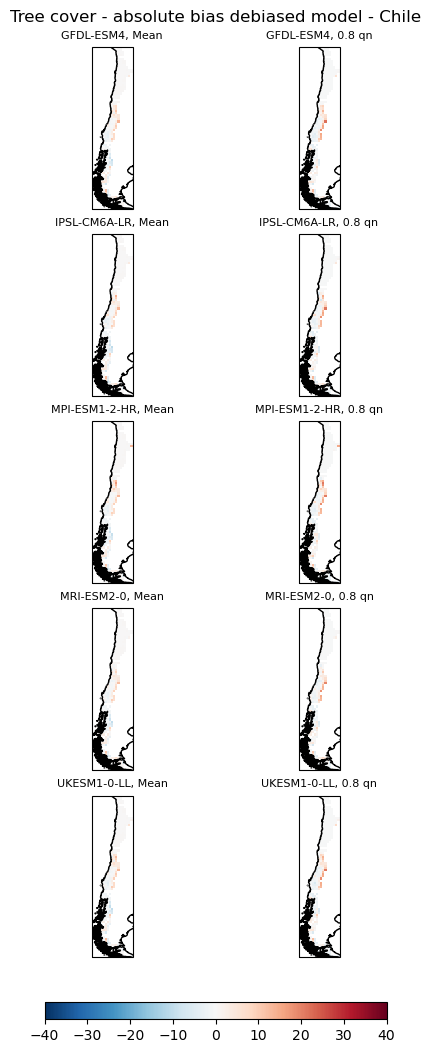

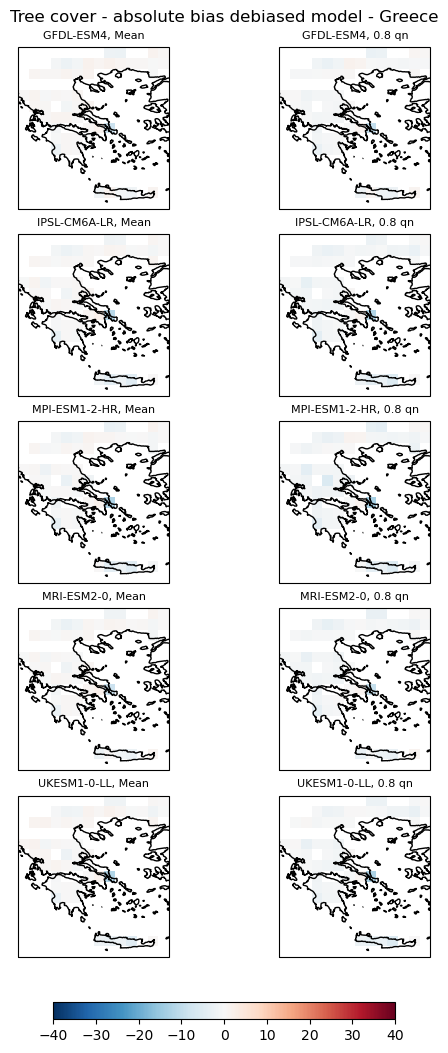

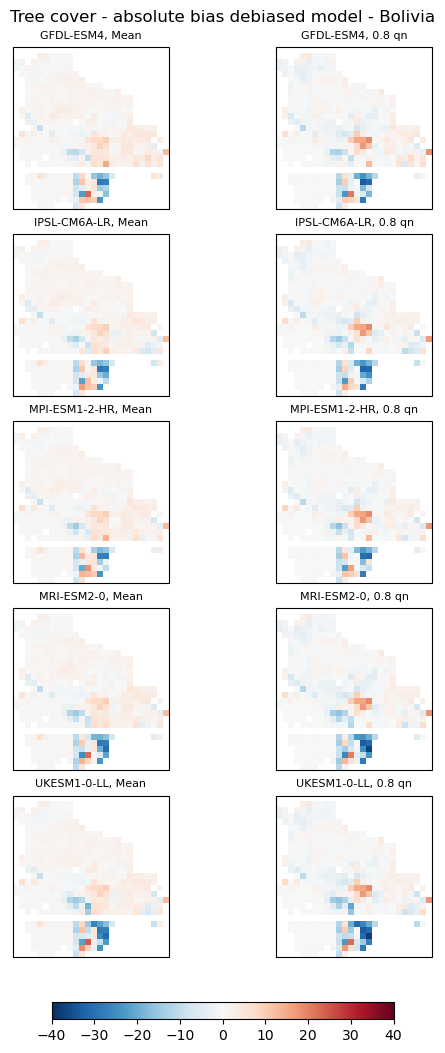

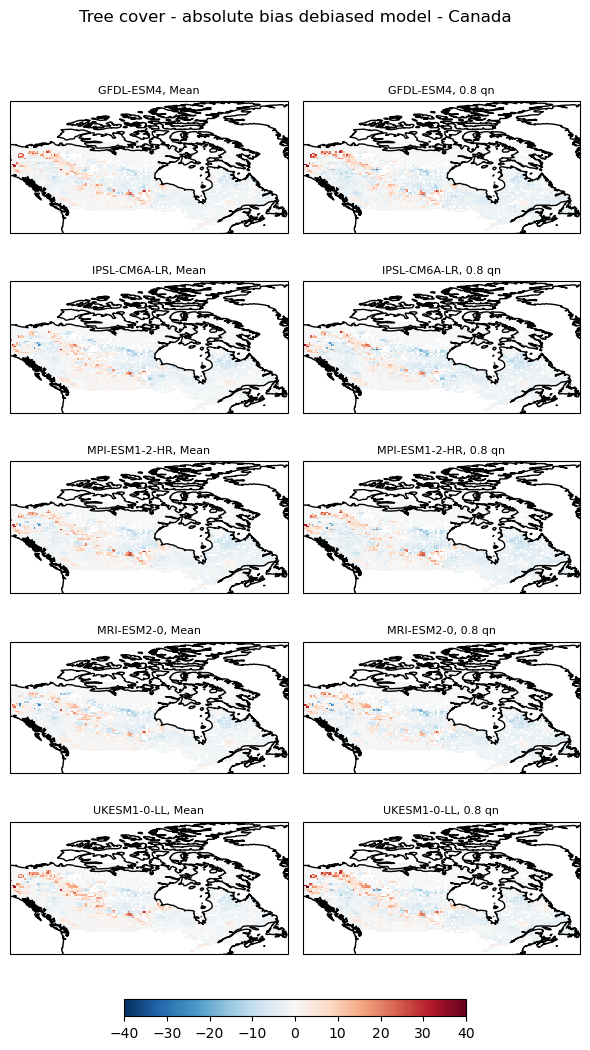

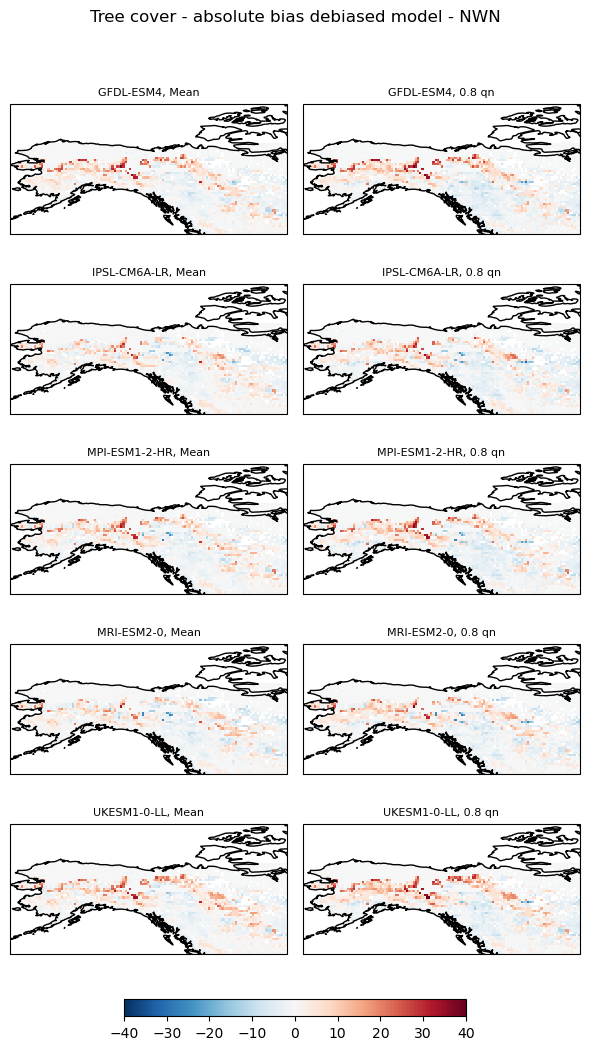

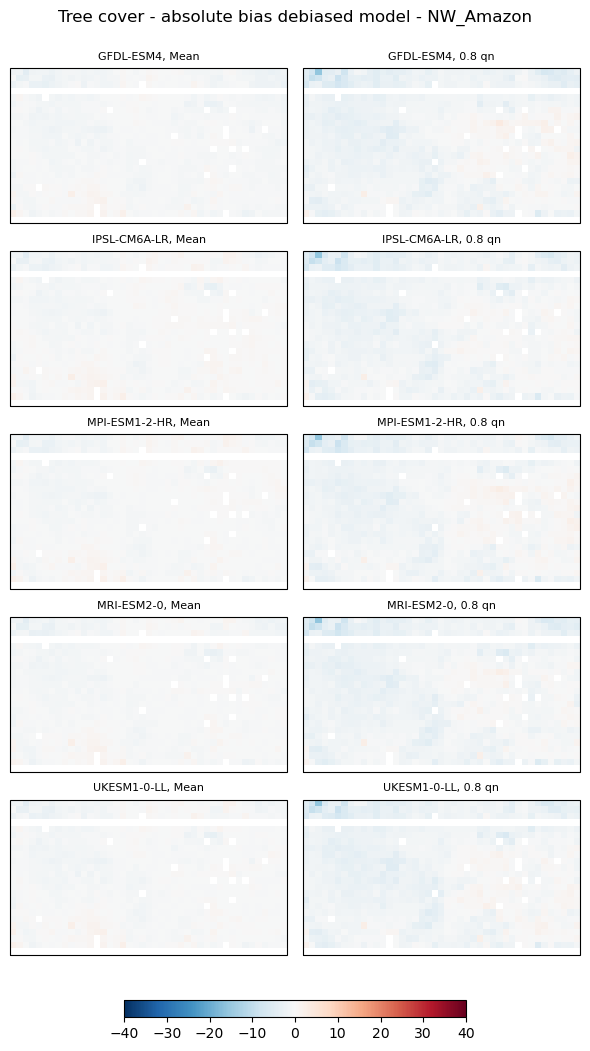

In [23]:


for region in regions:
    
    filtered_data = marginal_bias_df[marginal_bias_df['Correction Method']=='debiased']
    filtered_data = filtered_data[filtered_data['Region']==region]

    proj =ccrs.PlateCarree(central_longitude=0)
    fig, axes = plt.subplots(len(climate_models), 2, figsize=(6, 12), subplot_kw=dict(projection=proj))

    axis_max = datastore_vmax[region]
    axis_min = -datastore_vmax[region]
    
    for i in range(len(filtered_data.index)):
        da_xr = datastore_treecover[region+'_'+filtered_data['Climate Model'].iloc[i]+'_historical_cm_fut_debiased'][1, :, :]
        plot_data = xr.DataArray(filtered_data['Bias'].iloc[i], coords=da_xr.coords, dims=da_xr.dims, attrs=da_xr.attrs)

        cs = plot_data.plot(ax=axes.flat[i], cmap='RdBu_r',
                                              transform=ccrs.PlateCarree(), vmin=axis_min, vmax = axis_max,
                                             add_colorbar=False)
        axes.flat[i].coastlines()

        axes.flat[i].set_aspect('equal')
        axes.flat[i].set_title(label = filtered_data['Climate Model'].iloc[i]+', '+filtered_data['Metric'].iloc[i],
                              fontdict = {'fontsize': 8})




    #plt.show()
    fig.suptitle('Tree cover - absolute bias debiased model -  '+region)
    fig.tight_layout()
    cb = fig.colorbar(cs, ax=axes.ravel().tolist(), location='bottom', shrink=0.6, pad=0.04)
    plt.savefig(filepath+region+'_'+cm+'_bias_debiased_model.png')

#### merged plot

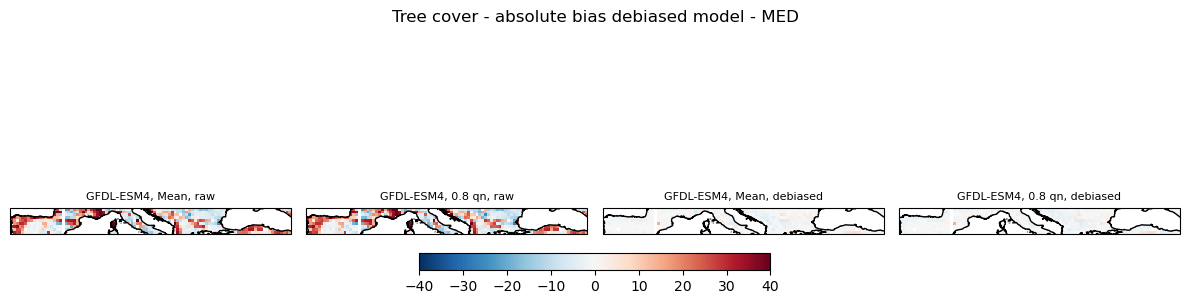

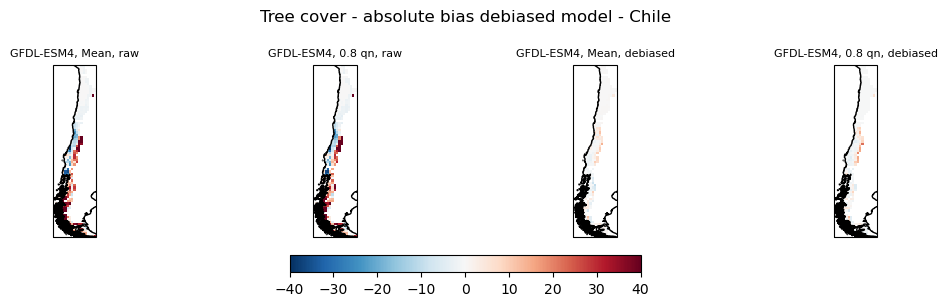

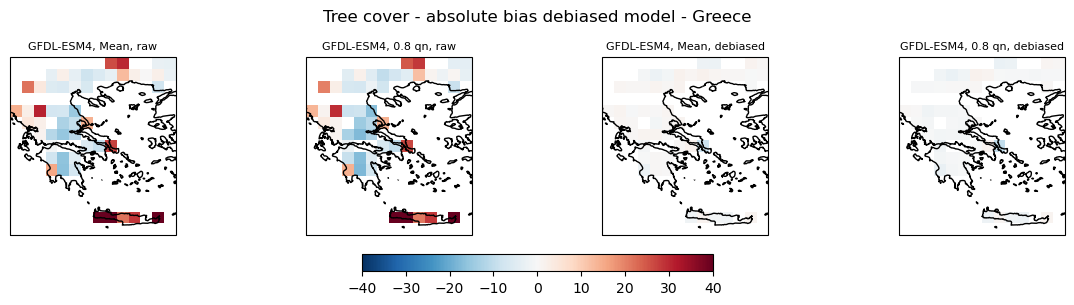

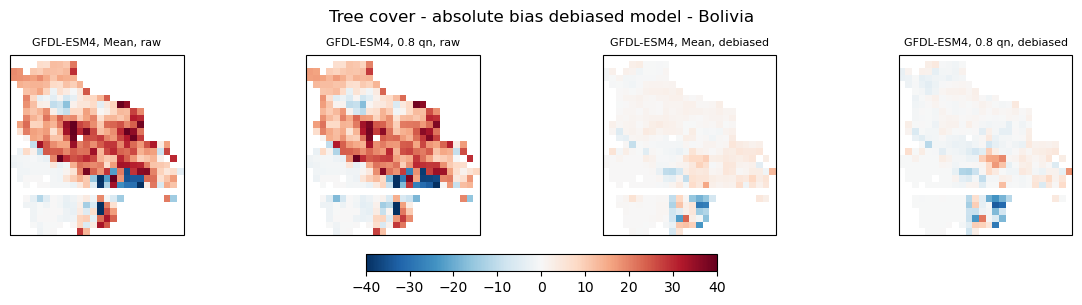

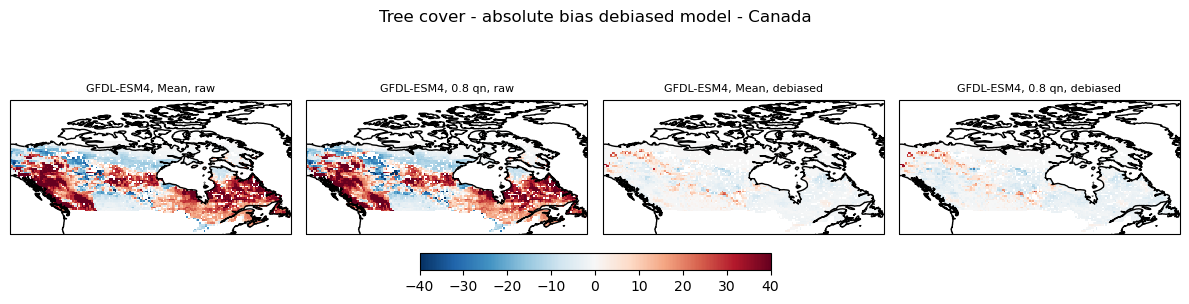

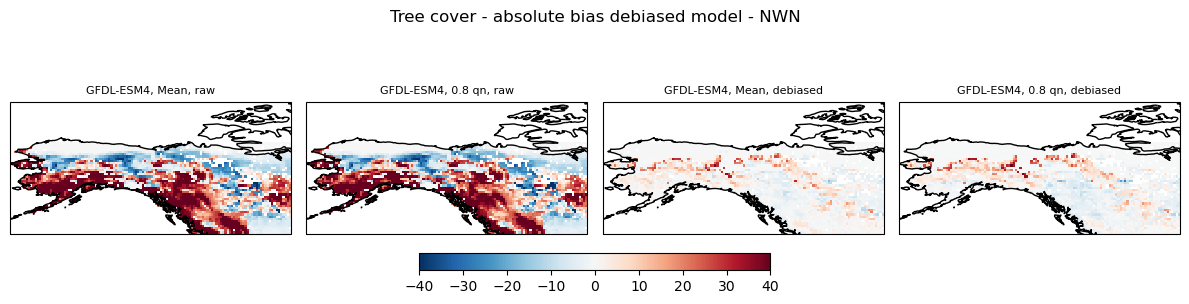

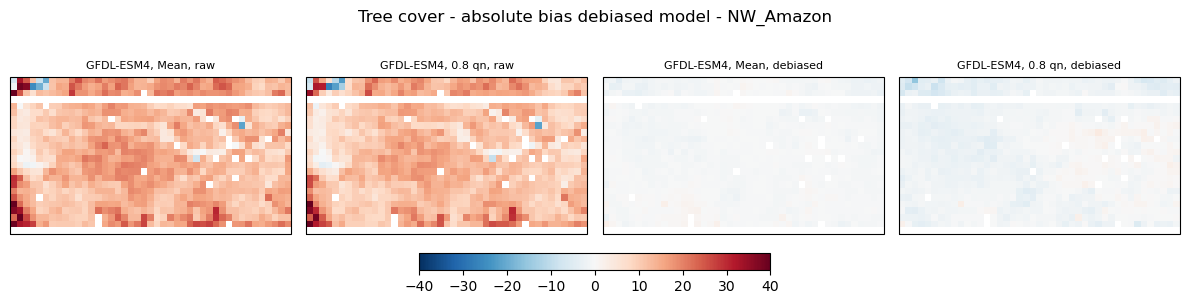

In [55]:
cm=climate_models[0]

for region in regions:
    
    #filtered_data = marginal_bias_df[marginal_bias_df['Correction Method']=='debiased']
    filtered_data = marginal_bias_df[marginal_bias_df['Region']==region]
    filtered_data = filtered_data[filtered_data['Climate Model']==cm]

    proj =ccrs.PlateCarree(central_longitude=0)
    fig, axes = plt.subplots(1, 4, figsize=(12, 3), subplot_kw=dict(projection=proj))

    axis_max = datastore_vmax[region]
    axis_min = -datastore_vmax[region]

    for i in range(len(filtered_data.index)):
        da_xr = datastore_treecover[region+'_'+cm+'_historical_cm_fut_debiased'][1, :, :]
        plot_data = xr.DataArray(filtered_data['Bias'].iloc[i], coords=da_xr.coords, dims=da_xr.dims, attrs=da_xr.attrs)

        cs = plot_data.plot(ax=axes.flat[i], cmap='RdBu_r',
                                              transform=ccrs.PlateCarree(), vmin=axis_min, vmax = axis_max,
                                             add_colorbar=False)
        axes.flat[i].coastlines()

        axes.flat[i].set_aspect('equal')
        axes.flat[i].set_title(label = filtered_data['Climate Model'].iloc[i]+', '+filtered_data['Metric'].iloc[i]+', '+filtered_data['Correction Method'].iloc[i],
                              fontdict = {'fontsize': 8})

    #plt.show()
    fig.suptitle('Tree cover - bias before and after correction - '+region)
    fig.tight_layout()
    cb = fig.colorbar(cs, ax=axes.ravel().tolist(), location='bottom', shrink=0.3, pad=0.08)
    plt.savefig(filepath+region+'_bias_merged.png')

### plot cumulative distribution function

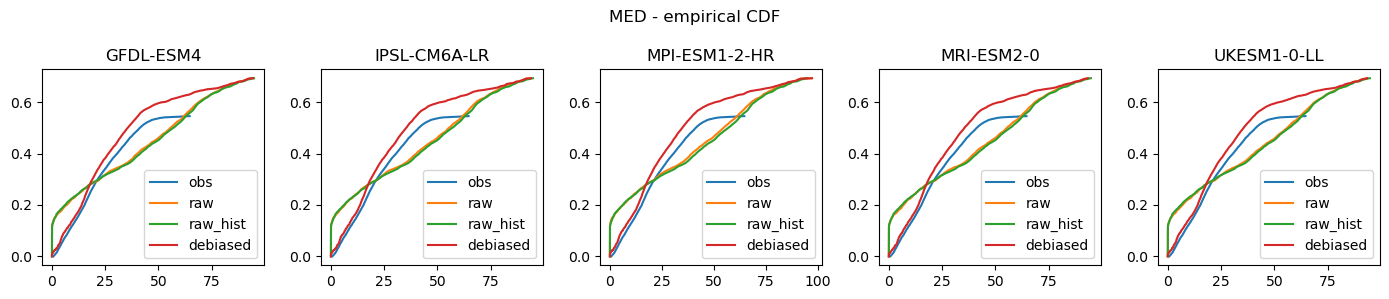

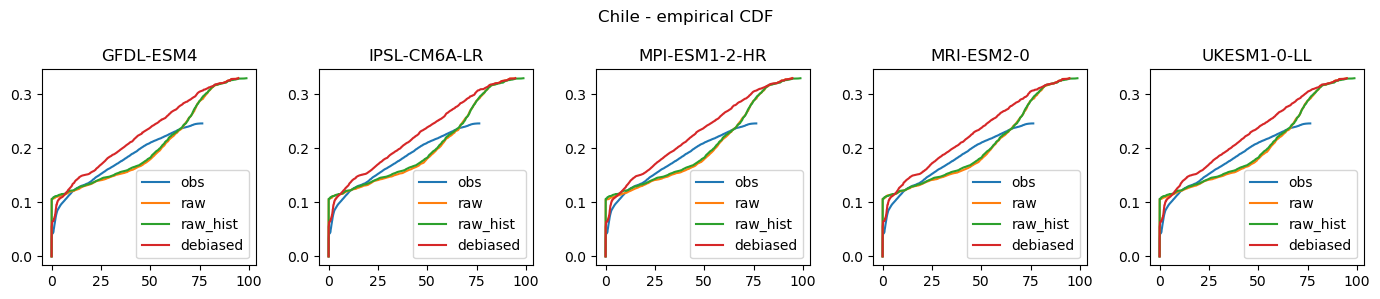

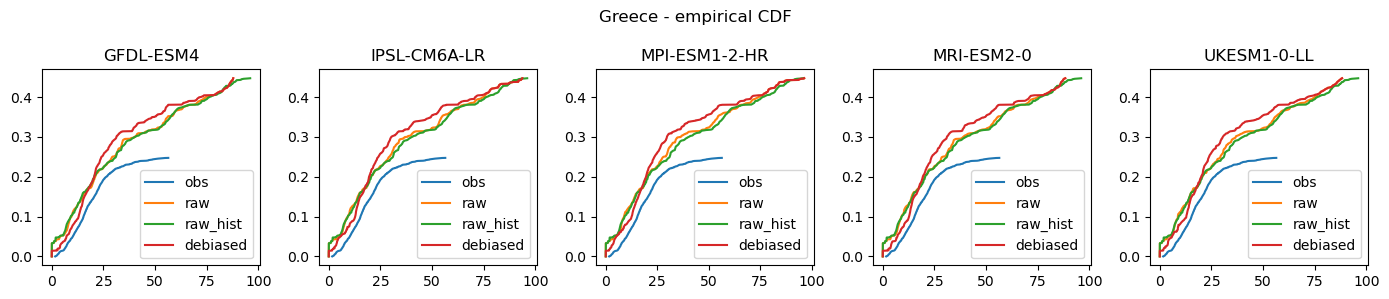

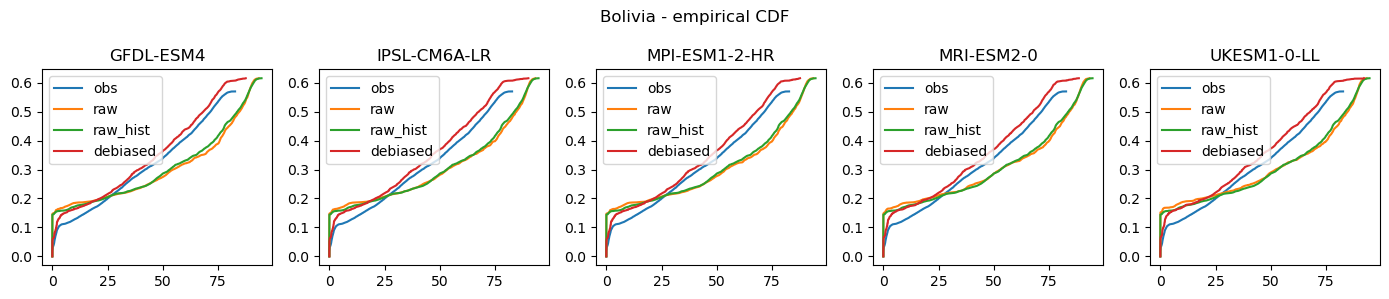

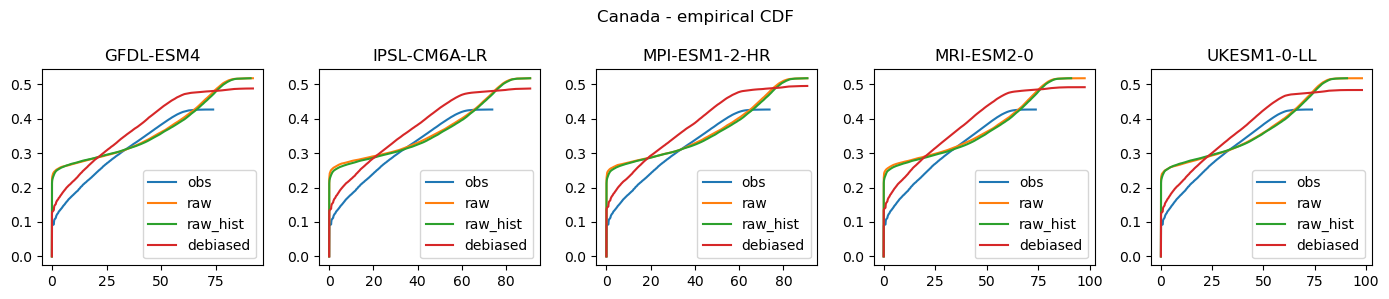

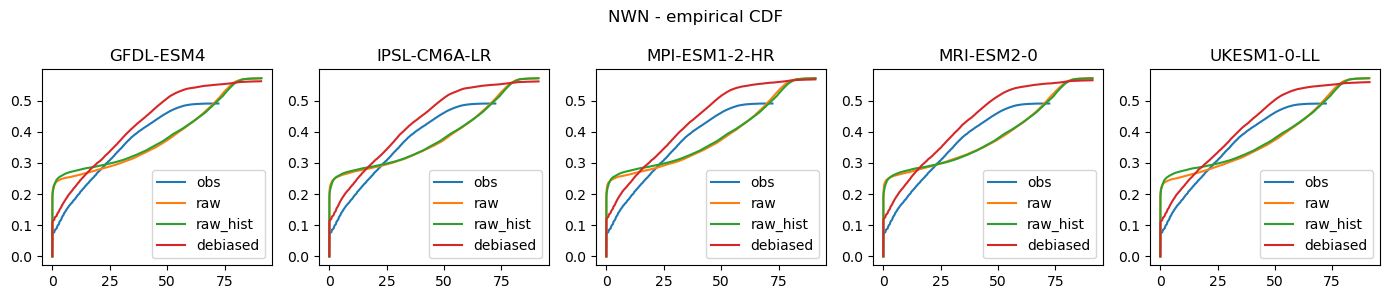

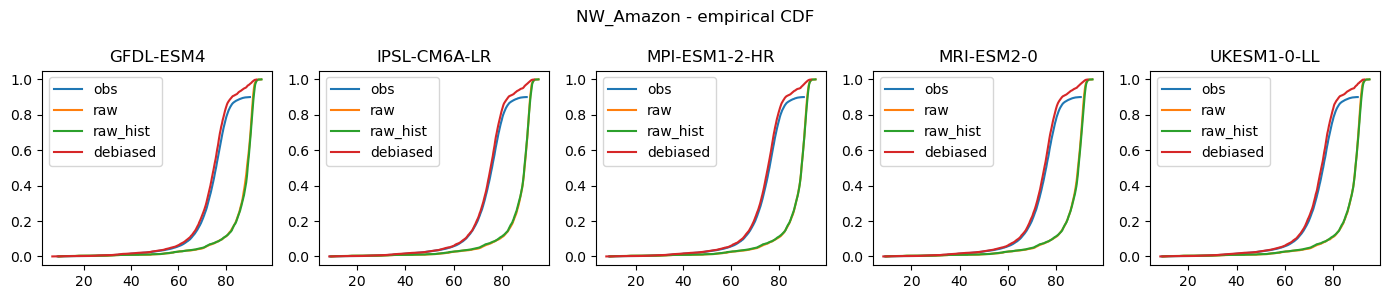

In [25]:
for region in regions:
    
    fig, ax = plt.subplots(1, len(climate_models), figsize=(14, 3))

    for i in range(len(climate_models)):
        
        cm = climate_models[i]

        
        obs = datastore_treecover[region+'_'+cm+'_obs']['tree_cover'].values.flatten()
        cm_hist = datastore_treecover[region+'_'+cm+'_historical_cm_fut']['tree_cover'].values.flatten()
        cm_hist_debiased = datastore_treecover[region+'_'+cm+'_historical_cm_fut_debiased'].values.flatten()
        cm_hist_2 = datastore_treecover[region+'_'+cm+'_cm_hist']['tree_cover'].values.flatten()
        
        obs[obs > 1e6] = np.nan
        cm_hist[cm_hist > 1e6] = np.nan
        cm_hist_2[cm_hist_2 > 1e6] = np.nan
        cm_hist_debiased[cm_hist_debiased > 1e6] = np.nan
        
        x_obs = np.sort(obs)
        x_cm_hist = np.sort(cm_hist)
        x_cm_hist_2 = np.sort(cm_hist_2)
        x_cm_hist_debiased = np.sort(cm_hist_debiased)
        
        N_cm=len(cm_hist)
        N_cm_2=len(cm_hist_2)
        N_cm2 =len(cm_hist_debiased)
        N_obs = len(obs)
        
        y_cm = np.arange(N_cm) / float(N_cm) 
        y_cm_2 = np.arange(N_cm_2) / float(N_cm_2)
        y_cm2 = np.arange(N_cm2) / float(N_cm2) 
        y_obs = np.arange(N_obs) / float(N_obs) 
        
        ax[i].plot(x_obs, y_obs, label='obs')
        ax[i].plot(x_cm_hist, y_cm, label='raw')
        ax[i].plot(x_cm_hist_2, y_cm_2, label='raw_hist')
        ax[i].plot(x_cm_hist_debiased, y_cm2, label='debiased')
        ax[i].legend()

        ax[i].set_title(label = cm)
        
    fig.suptitle(region + ' - empirical CDF')
    plt.tight_layout()

    plt.savefig(filepath+region+'_cdfs.png')

### timeseries

In [30]:
scenarios_cut = ['ssp126', 'ssp370', 'ssp585']
colors = ["green", "orange", "red"]

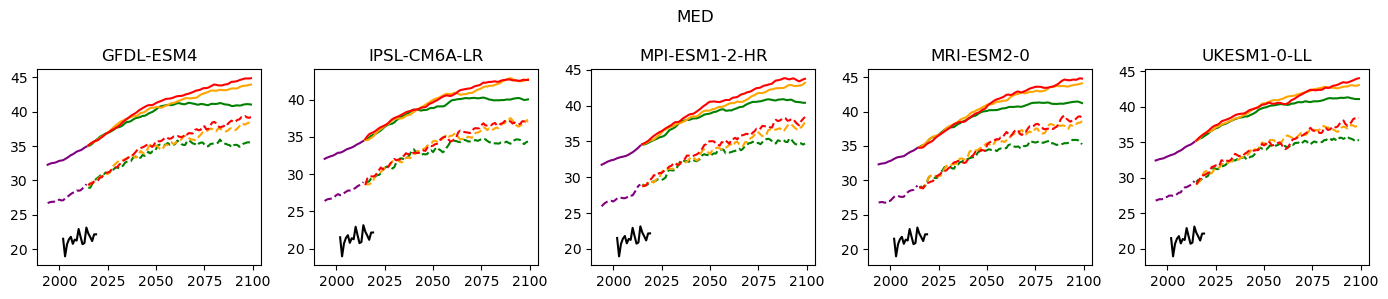

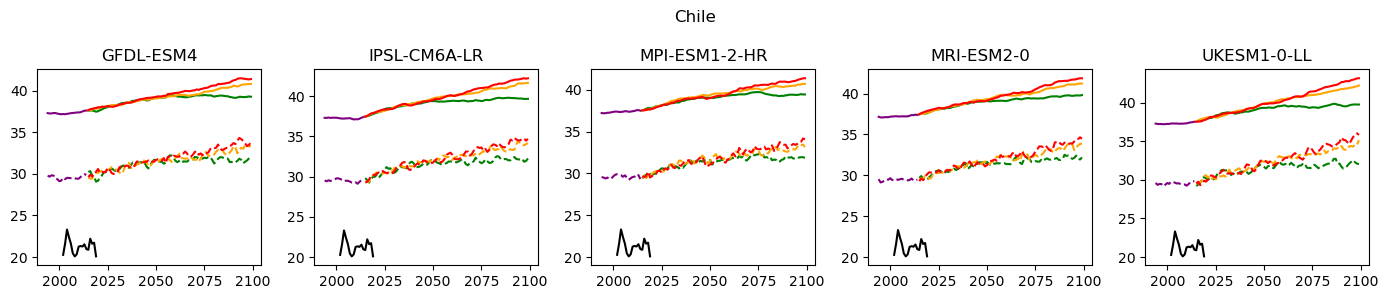

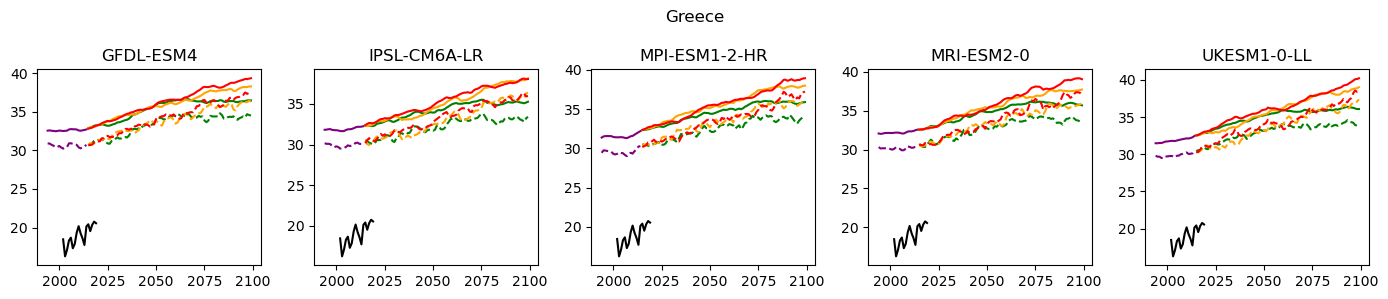

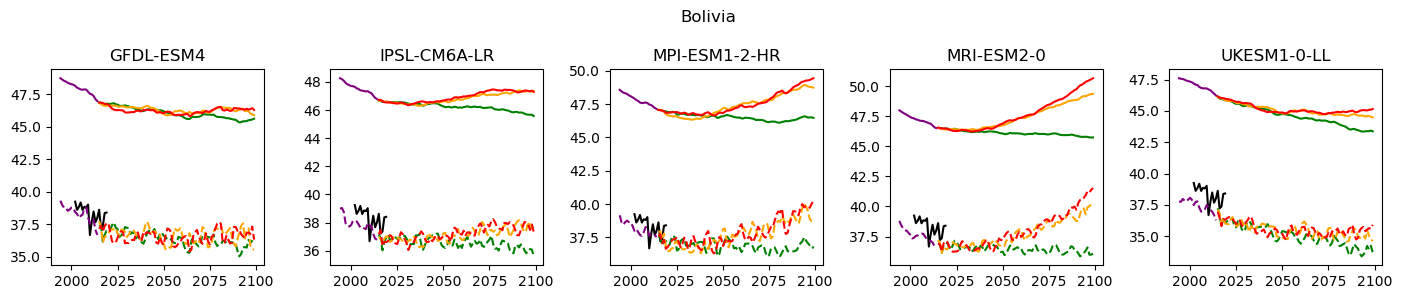

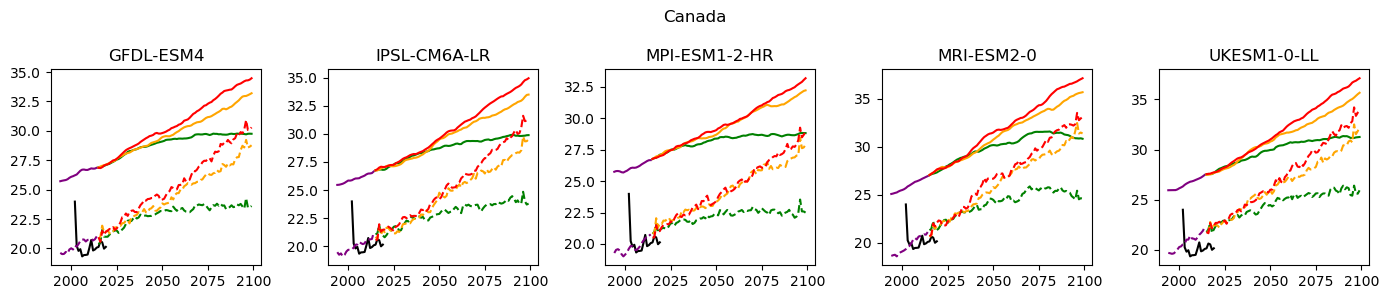

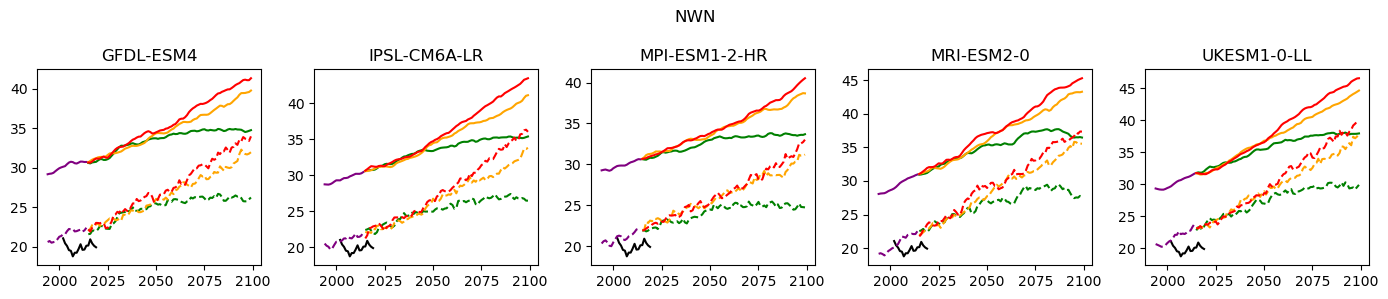

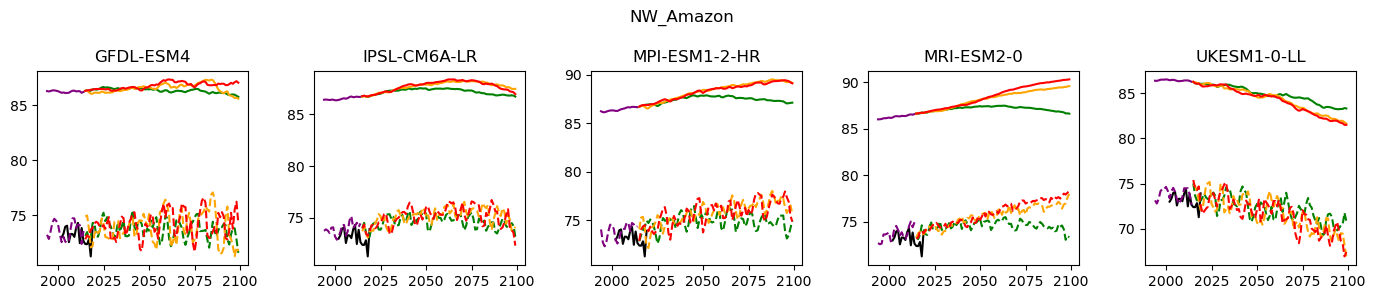

In [33]:
for region in regions:
    
    fig, ax = plt.subplots(1, len(climate_models), figsize=(14, 3))

    for i in range(len(climate_models)):
        
        cm = climate_models[i]
        
        obs = datastore_treecover[region+'_'+cm+'_obs']['tree_cover']
        cm_hist = datastore_treecover[region+'_'+cm+'_historical_cm_fut']['tree_cover']
        cm_hist_debiased = datastore_treecover[region+'_'+cm+'_historical_cm_fut_debiased']
        
        obs_values = datastore_treecover[region+'_'+cm+'_obs']['tree_cover'].values
        obs_values[obs_values > 1e6] = np.nan
        
        cm_hist_values = datastore_treecover[region+'_'+cm+'_historical_cm_fut']['tree_cover'].values
        cm_hist_values[cm_hist_values > 1e6] = np.nan
        
        cm_hist_debiased_values = datastore_treecover[region+'_'+cm+'_historical_cm_fut_debiased'].values
        cm_hist_debiased_values[cm_hist_debiased_values > 1e6] = np.nan
        
        ax[i].plot(year(obs.time.values), np.nanmean(obs_values.reshape((obs_values.shape[0], -1)), axis = -1), color = 'black')
        ax[i].plot(year(cm_hist.time.values), np.nanmean(cm_hist_values.reshape((cm_hist.shape[0], -1)), axis = -1), color = 'purple')
        ax[i].plot(year(cm_hist_debiased.time.values), np.nanmean(cm_hist_debiased_values.reshape((cm_hist_debiased.shape[0], -1)), axis = -1), color = 'purple', linestyle="--")
        
        ax[i].set_title(label = cm)
        
        for scenario, color in zip(scenarios_cut, colors):
            
            cm_fut = datastore_treecover[region+'_'+cm+'_'+scenario+'_cm_fut']['tree_cover']
            cm_fut_debiased = datastore_treecover[region+'_'+cm+'_'+scenario+'_cm_fut_debiased']
            
            cm_fut_values = datastore_treecover[region+'_'+cm+'_'+scenario+'_cm_fut']['tree_cover'].values
            cm_fut_values[cm_fut_values > 1e6] = np.nan
            
            cm_fut_debiased_values = datastore_treecover[region+'_'+cm+'_'+scenario+'_cm_fut_debiased'].values
            cm_fut_debiased_values[cm_fut_debiased_values > 1e6] = np.nan
            
            ax[i].plot(year(cm_fut.time.values), np.nanmean(cm_fut_values.reshape((cm_fut_values.shape[0], -1)), axis = -1), color = color)
            ax[i].plot(year(cm_fut_debiased.time.values), np.nanmean(cm_fut_debiased_values.reshape((cm_fut_debiased_values.shape[0], -1)), axis = -1), color = color, linestyle = "--")
            
    fig.suptitle(region)
    plt.tight_layout()

    plt.savefig(filepath+region+'_timeseries.png')



### Trend

In [48]:
vmax2 = [80, 80, 80, 80, 80]
vmax2 = [20, 20, 20, 20, 20]

datastore_vmax2 = {}
i=0
for region in modified_regions:
    datastore_vmax2[region] = vmax2[i]
    i=i+1

In [37]:
modified_regions = ["Greece", "Bolivia", "Canada", "NWN", 'NW_Amazon']

In [45]:
trend_bias = []

for region in modified_regions:

    for cm in climate_models:

        for scenario in ['ssp126', 'ssp370', 'ssp585']:
            
            print(cm, region, scenario)
            
            raw_fut = datastore_treecover[region+'_'+cm+'_'+scenario+'_cm_fut']['tree_cover'].values
            raw_hist = datastore_treecover[region+'_'+cm+'_historical_cm_fut']['tree_cover'].values
            db_fut = datastore_treecover[region+'_'+cm+'_'+scenario+'_cm_fut_debiased'].values
            db_hist = datastore_treecover[region+'_'+cm+'_historical_cm_fut_debiased'].values
            #db_hist = datastore_treecover[region+'_'+cm+'_obs']['tree_cover'].values
                        
            raw_fut[raw_fut > 1e6] = np.nan
            raw_hist[raw_hist > 1e6] = np.nan
            db_fut[db_fut > 1e6] = np.nan
            db_hist[db_hist > 1e6] = np.nan
            
            trend_raw = np.mean(raw_fut, axis=0) - np.mean(raw_hist, axis=0)
            print(raw_fut.shape)
            trend_db = np.mean(db_fut, axis=0) - np.mean(db_hist, axis=0)
            trend_bias_data = (trend_db - trend_raw)#/trend_raw

            trend_bias.append(pd.DataFrame(
                                    data={
                                        "Climate Model": [cm],
                                        "Scenario": [scenario],
                                        "Region": [region],
                                        "Metric": ["Mean"],
                                        "Bias": [trend_bias_data],
                                    }))


trend_bias_df = pd.concat(trend_bias)

GFDL-ESM4 Greece ssp126
(85, 15, 14)
GFDL-ESM4 Greece ssp370
(85, 15, 14)
GFDL-ESM4 Greece ssp585
(85, 15, 14)
IPSL-CM6A-LR Greece ssp126
(85, 15, 14)
IPSL-CM6A-LR Greece ssp370
(85, 15, 14)
IPSL-CM6A-LR Greece ssp585
(85, 15, 14)
MPI-ESM1-2-HR Greece ssp126
(85, 15, 14)
MPI-ESM1-2-HR Greece ssp370
(85, 15, 14)
MPI-ESM1-2-HR Greece ssp585
(85, 15, 14)
MRI-ESM2-0 Greece ssp126
(85, 15, 14)
MRI-ESM2-0 Greece ssp370
(85, 15, 14)
MRI-ESM2-0 Greece ssp585
(85, 15, 14)
UKESM1-0-LL Greece ssp126
(85, 15, 14)
UKESM1-0-LL Greece ssp370
(85, 15, 14)
UKESM1-0-LL Greece ssp585
(85, 15, 14)
GFDL-ESM4 Bolivia ssp126
(85, 27, 26)
GFDL-ESM4 Bolivia ssp370
(85, 27, 26)
GFDL-ESM4 Bolivia ssp585
(85, 27, 26)
IPSL-CM6A-LR Bolivia ssp126
(85, 27, 26)
IPSL-CM6A-LR Bolivia ssp370
(85, 27, 26)
IPSL-CM6A-LR Bolivia ssp585
(85, 27, 26)
MPI-ESM1-2-HR Bolivia ssp126
(85, 27, 26)
MPI-ESM1-2-HR Bolivia ssp370
(85, 27, 26)
MPI-ESM1-2-HR Bolivia ssp585
(85, 27, 26)
MRI-ESM2-0 Bolivia ssp126
(85, 27, 26)
MRI-ESM2-0 Bo

/Users/fionaspuler/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:180: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Users/fionaspuler/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:180: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Users/fionaspuler/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:180: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Users/fionaspuler/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:180: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Users/fionaspuler/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:180: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims

/Users/fionaspuler/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:180: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Users/fionaspuler/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:180: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Users/fionaspuler/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:180: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Users/fionaspuler/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:180: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Users/fionaspuler/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:180: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims

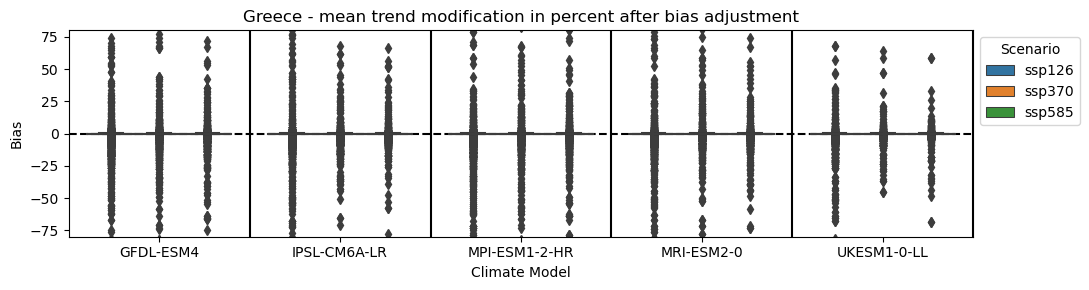

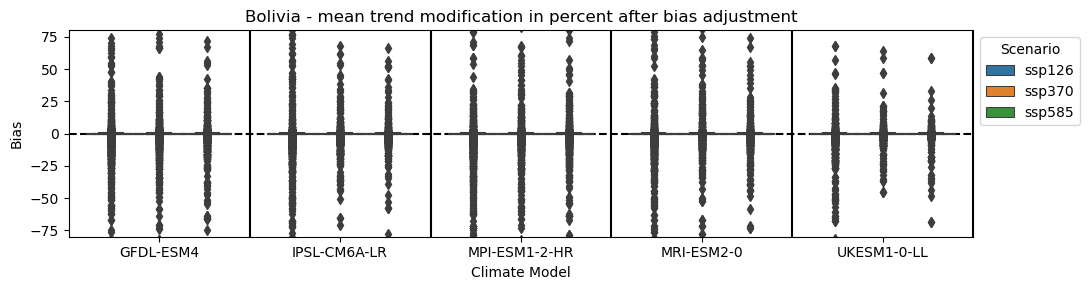

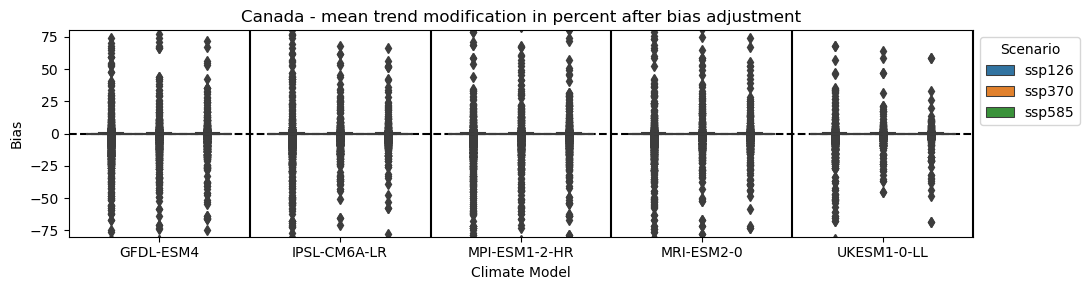

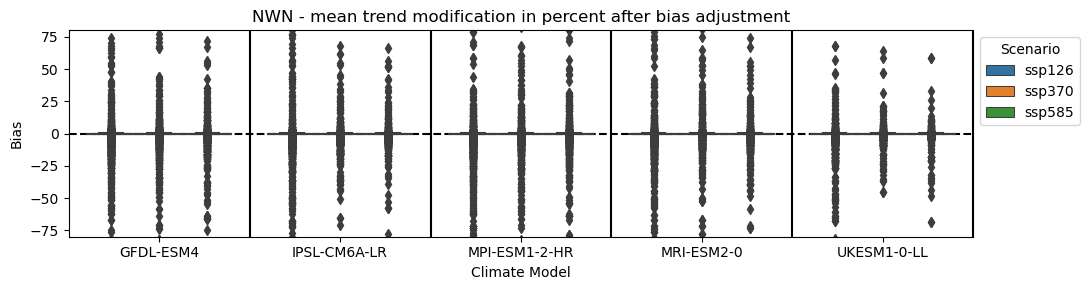

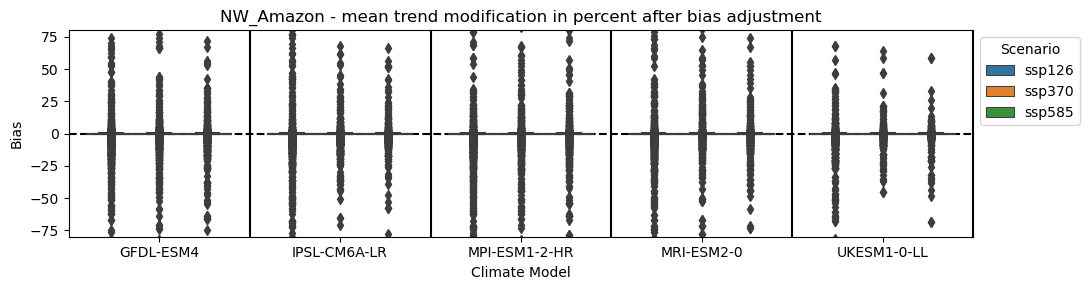

In [200]:
trend_difference_unpacked = _unpack_df_of_numpy_arrays(df=trend_bias_df, numpy_column_name="Bias")

import seaborn as sns

for region in modified_regions:
    
    filtered_data = trend_difference_unpacked[trend_difference_unpacked['Metric']=="Mean"]

    fig, ax = plt.subplots(figsize=(11,3))
    sns.boxplot(ax=ax, data=filtered_data, x="Climate Model", y="Bias", hue="Scenario")
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
    [ax.axvline(x + 0.5, color="k") for x in ax.get_xticks()]
    [ax.axhline(linestyle='--', color="k")]
    plt.ylim(-datastore_vmax2[region], datastore_vmax2[region])
    plt.title(region + ' - mean trend modification in percent after bias adjustment')
    plt.tight_layout()
    plt.savefig(filepath+region+'_trend.png')

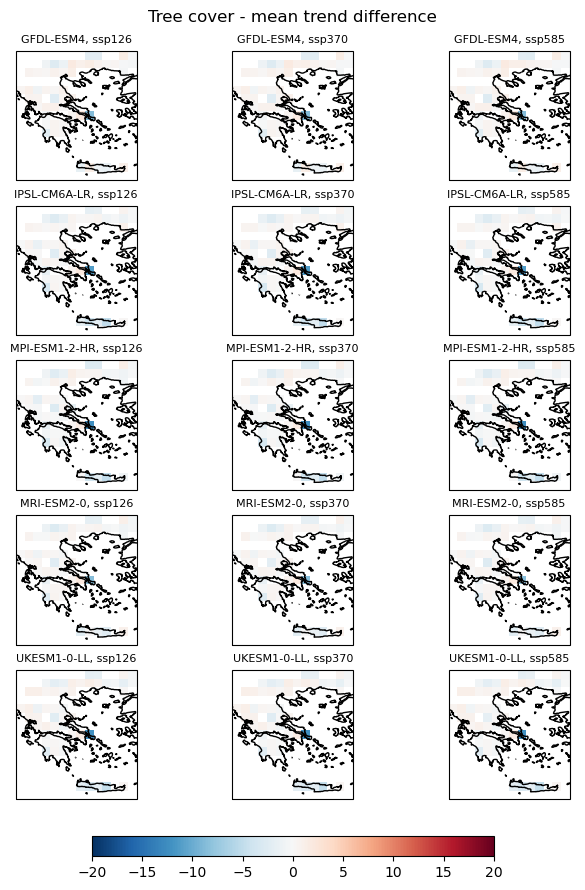

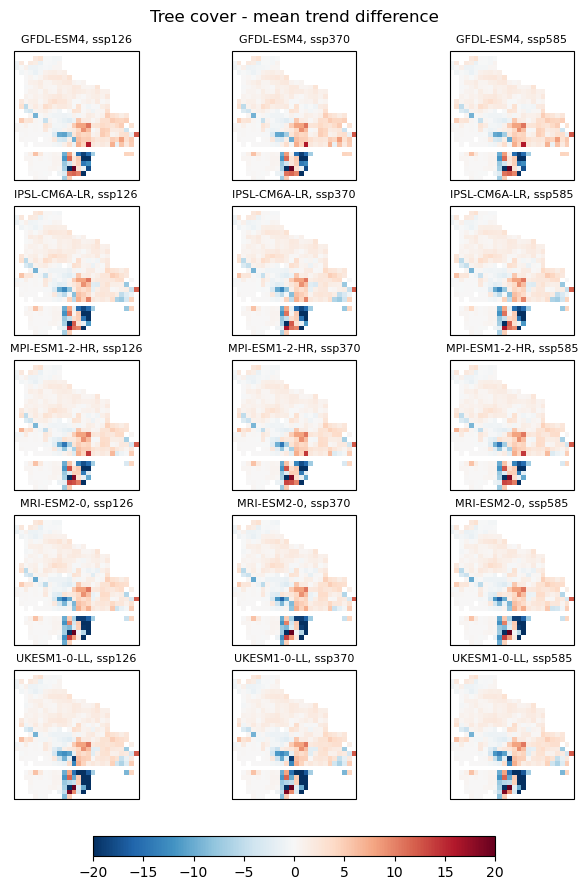

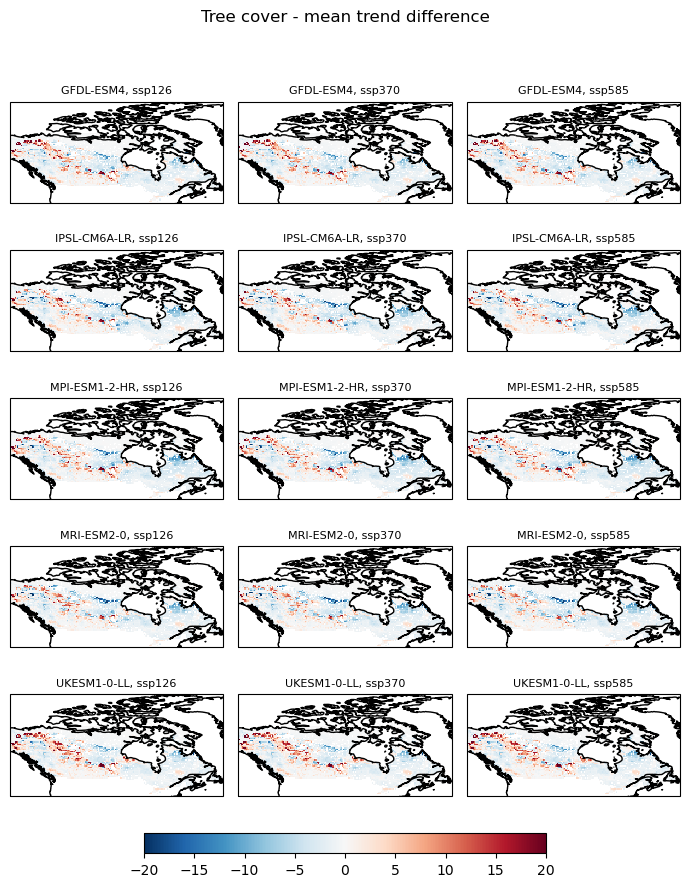

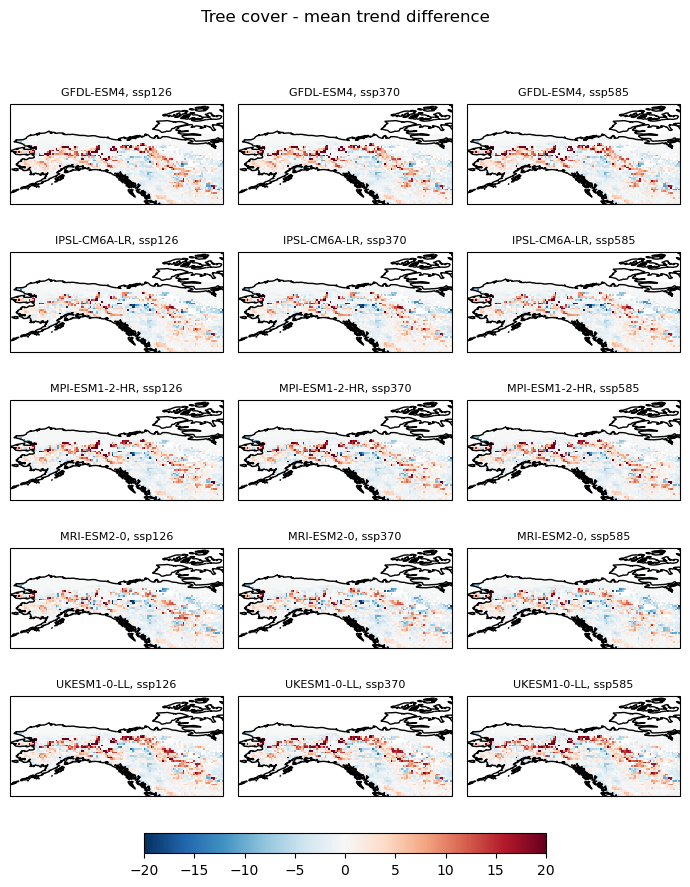

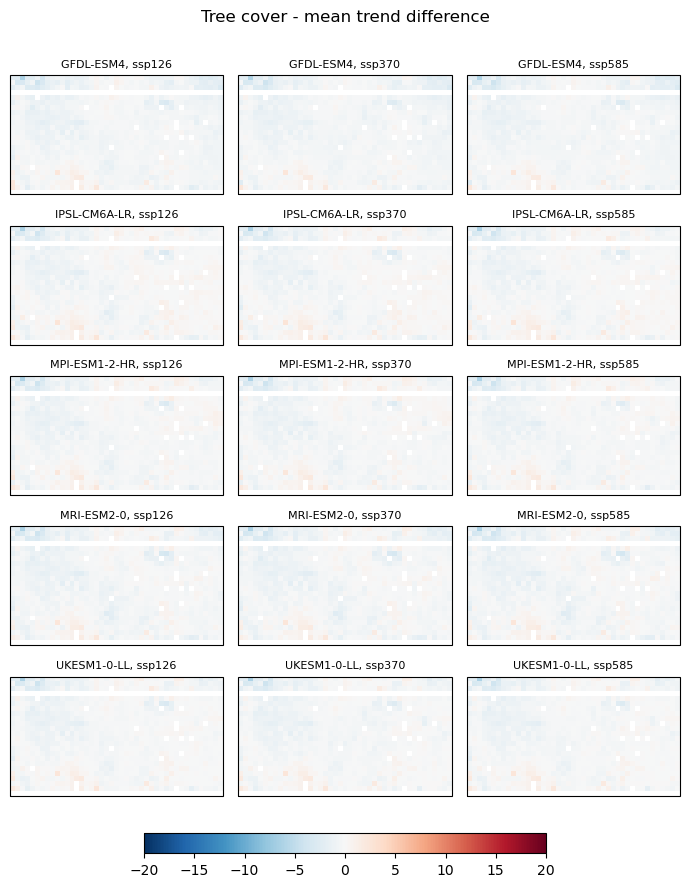

In [49]:
for region in modified_regions:

    filtered_data = trend_bias_df[trend_bias_df['Region']==region]

    proj =ccrs.PlateCarree(central_longitude=0)
    fig, axes = plt.subplots(len(climate_models), 3, figsize=(7, 10), subplot_kw=dict(projection=proj))

    axis_max = datastore_vmax2[region]
    axis_min = -datastore_vmax2[region]

    for i in range(len(filtered_data.index)):

        da_xr = datastore_treecover[region+'_'+filtered_data['Climate Model'].iloc[i]+'_historical_cm_fut_debiased'][1, :, :]
        #da_xr = datastore_treecover[filtered_data['Climate Model'].iloc[i]+'_historical_raw'][1, :, :]
        plot_data = xr.DataArray(filtered_data['Bias'].iloc[i], coords=da_xr.coords, dims=da_xr.dims, attrs=da_xr.attrs)

        cs = plot_data.plot(ax=axes.flat[i], cmap='RdBu_r',
                                              transform=ccrs.PlateCarree(), vmin=axis_min, vmax = axis_max,
                                             add_colorbar=False)
        axes.flat[i].coastlines()

        axes.flat[i].set_aspect('equal')
        axes.flat[i].set_title(label = filtered_data['Climate Model'].iloc[i]+', '+filtered_data['Scenario'].iloc[i],
                              fontdict = {'fontsize': 8})

    #plt.show()
    fig.suptitle('Tree cover - mean trend difference')
    fig.tight_layout()
    cb = fig.colorbar(cs, ax=axes.ravel().tolist(), location='bottom', shrink=0.6, pad=0.04)

## Text

The results were evaluated in terms of the ability of the bias correction method to adjust over the historical period, as well as preserve the trend between the future and historical period. It was found that the method corrects the bias well over the historical period for most gridcells (>95%) the trend between the future and historical period is preserved up to 1% difference. To demonstrate the evaluation conducted, Figure XX shows the results for treecover over XXX REGION XXX. The plots for the remaining regions, including tree and no-tree cover, can be found in the SI. Investigating the timeseries of average treecover over the region, we find that the correction method reduces the bias over the historical period and matches the future period to the historical period (Figure XXa). The cumulative distribution functions of average tree cover in observations and model match better after bias adjustment (Figure XXb), and we find that the improvement in both mean and 80th percentile hold across the entire region (Figure XXc). The trend between future and historical period is preserved for the majority of grid-cells, with some locations seeing changes up to 40%.